In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP

from sklearn.metrics import roc_auc_score
from pandarallel import pandarallel

import seaborn as sns
sns.set(style = 'white', font_scale=1.5)
pandarallel.initialize(nb_workers = 8, progress_bar=True) # initialize(36) or initialize(os.cpu_count()-1)

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distanc

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
import sys
sys.path.insert(0, '/home/was966/Research/PSOG/')
from gdd.correlation import pairwise_correlation
from gdd.combination import pairwise_combination
from gdd.score import Xy_score
from gdd.plot import plot_batch
BEST = ['PIK3CD', 'TOLLIP']
TEST = [('MAP4K1','TBX3'), ('MAP4K1', 'AGER')]

In [78]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/6575/'

tcga_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.TABLE'))
itrp_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE'))
itrp_tpm_crt = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE.CORRECT'))

tcga_patient = pd.read_pickle(os.path.join(data_path, 'PATIENT.TCGA.TABLE'))
tcga_patient['cohort'] = tcga_patient.cancer_type
itrp_patient = pd.read_pickle(os.path.join(data_path, 'PATIENT.ITRP.TABLE'))
gene = pd.read_pickle(os.path.join(data_path, 'GENE.TABLE'))

dfp1 = itrp_tpm.join(itrp_patient.cohort)
dfp2 = tcga_tpm.join(tcga_patient.cohort)
dfp2 = dfp2[dfp2.cohort == 'TCGA-SKCM']
dfp = pd.concat([dfp1, dfp2])

In [79]:
m1 = (itrp_tpm['MAP4K1'] - itrp_tpm['TBX3'])
m1.name = 'MAP4K1 - TBX3'

m2 = (itrp_tpm['MAP4K1'] - itrp_tpm['AGER'])
m2.name = 'MAP4K1 - AGER'

In [162]:
y_col = 'Freeman_response_correction'
dfxy = itrp_patient[[y_col]].join(m1).join(m2).dropna()
dfxy[y_col].unique()

array(['R', 'NR'], dtype=object)

In [163]:
#dfxy[y_col] = dfxy[y_col].map({'R':'X', 'NR': 'Y'})
#dfxy = dfxy.dropna()

In [164]:
itrp_patient.columns

Index(['Sample_id', 'RECIST', 'Patient', 'Age', 'Gender', 'Primary_tumor',
       'Overall_survival', 'Alive (Y=1, No=0)', 'Timing', 'Freeman_response',
       'Therapy', 'Prior_CTLA4', 'cohort', 'tmb.dan', 'tmb.wang',
       'participant', 'is_in_FreeMan', 'rnaseq_id', 'RECIST_Response',
       'Freeman_response_correction'],
      dtype='object')

In [166]:
itrp_patient[['cohort',y_col]].groupby(['cohort',y_col]).size().unstack()

Freeman_response_correction,NR,R
cohort,,
Allen,26,13
Gide,32,41
Hugo,17,9
Liu,66,41
MGH,24,14
Riaz,41,10


In [167]:
itrp_patient[['cohort',y_col]].groupby(['cohort',y_col]).size().unstack()

Freeman_response_correction,NR,R
cohort,,
Allen,26,13
Gide,32,41
Hugo,17,9
Liu,66,41
MGH,24,14
Riaz,41,10


In [168]:
itrp_patient[['cohort',y_col]].groupby(['cohort',y_col]).size().unstack()

Freeman_response_correction,NR,R
cohort,,
Allen,26,13
Gide,32,41
Hugo,17,9
Liu,66,41
MGH,24,14
Riaz,41,10


In [169]:
mic = Xy_score(dfxy, y_col, method='mic', n_jobs=6)
prc = Xy_score(dfxy, y_col, method='prc', n_jobs=6)
roc = Xy_score(dfxy, y_col, method='roc', n_jobs=6)

100%|##########| 2/2 [00:00<00:00, 1807.50it/s]


In [170]:
score = mic.join(prc).join(roc)
score['mean'] = score.mean(axis=1)
score = score.sort_values('roc')

In [171]:
score

,mic,prc,roc,mean
gene_name,,,,
MAP4K1 - TBX3,0.038412,0.536617,0.629513,0.401514
MAP4K1 - AGER,0.027647,0.554715,0.670055,0.417472


100%|##########| 1/1 [00:00<00:00, 1582.76it/s]


,,roc,prc
cohort,gene_name,,
Allen,MAP4K1 - AGER,0.674556,0.482607
Gide,MAP4K1 - AGER,0.678354,0.655044
Hugo,MAP4K1 - AGER,0.712418,0.437103
Liu,MAP4K1 - AGER,0.536585,0.433561
MGH,MAP4K1 - AGER,0.610119,0.578710
Riaz,MAP4K1 - AGER,0.873171,0.749879


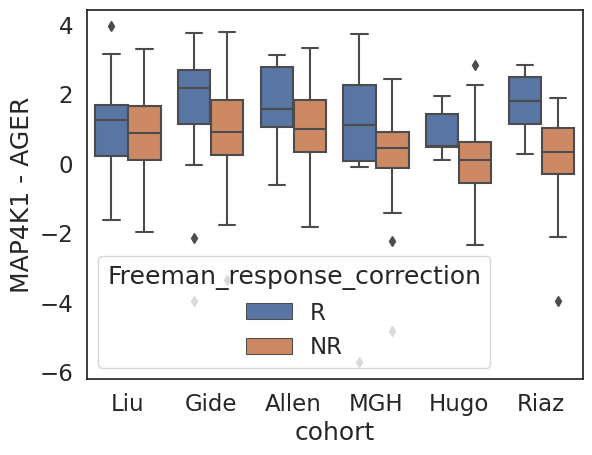

In [172]:
yc = 'MAP4K1 - AGER'
dfpp = dfxy.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp, y = yc, x = 'cohort', hue = y_col)
roc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, y_col]], y_col, method='roc', n_jobs=6))
prc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, y_col]], y_col, method='prc', n_jobs=6))
roc.join(prc)

In [173]:
roc.join(prc).mean()

roc    0.680867
prc    0.556151
dtype: float64

<Axes: xlabel='cohort', ylabel='MAP4K1 - TBX3'>

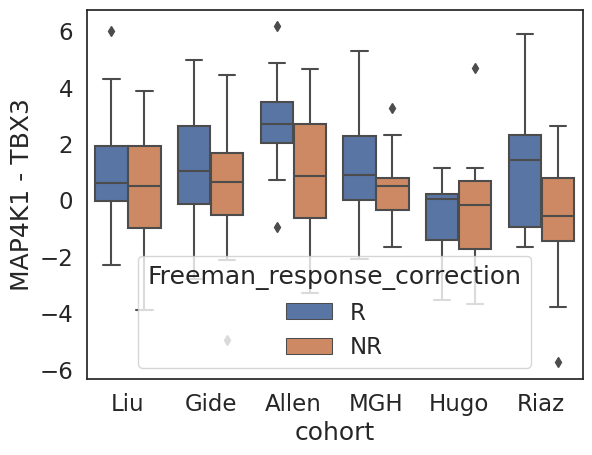

In [174]:
yc = 'MAP4K1 - TBX3'
dfpp = dfxy.join(itrp_patient.cohort)[[yc, 'cohort', y_col]]
sns.boxplot(dfpp, y = yc, x = 'cohort', hue = y_col)

In [175]:
roc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, y_col]], y_col, method='roc', n_jobs=6))
prc = dfpp.groupby('cohort').apply(lambda dfxy:Xy_score(dfxy[[yc, y_col]], y_col, method='prc', n_jobs=6))
roc.join(prc)

100%|##########| 1/1 [00:00<00:00, 1091.13it/s]


,,roc,prc
cohort,gene_name,,
Allen,MAP4K1 - TBX3,0.757396,0.618923
Gide,MAP4K1 - TBX3,0.587652,0.656129
Hugo,MAP4K1 - TBX3,0.529412,0.337406
Liu,MAP4K1 - TBX3,0.559867,0.461676
MGH,MAP4K1 - TBX3,0.633929,0.602507
Riaz,MAP4K1 - TBX3,0.709756,0.510032


In [176]:
roc.join(prc).mean()

roc    0.629669
prc    0.531112
dtype: float64